<a href="https://colab.research.google.com/github/claudeshyaka/master-project-repo/blob/main/TSTransfomer_ProbabilisticForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Transformer - Probabilistic Forecast

## Load Dependencies

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q gluonts datasets transformers evaluate accelerate gluonts ujson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import tempfile
import random
import matplotlib.pyplot as plt

from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset


## Data (Per-unit Voltage Magnitude)


### Dataset

*   This dataset resulted from running powerflow analysis on a network from the Simbench dataset which contains 372 buses.
*   The data corresponds to the per-unit voltage magnitude at each bus recorded every 15 minutes during the span of one year.

In [4]:
output_dir = os.path.join("/content/drive/MyDrive/datasource",
                          "time_series_test")
bus_vm_pu_data = os.path.join(output_dir, "res_bus/vm_pu.xlsx")
bus_vm_pu_df = pd.read_excel(bus_vm_pu_data, index_col=0)
bus_vm_pu_df.head()

,0,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,1.068,1.068,1.068,1.068,1.068,1.085174,1.085174,1.085174,1.085174,1.085174,...,1.095028,1.095028,1.095028,1.085090,1.085090,1.085090,1.085090,1.085090,1.085090,1.085090
1,1.068,1.068,1.068,1.068,1.068,1.082818,1.082818,1.082818,1.082818,1.082818,...,1.091864,1.091864,1.091864,1.082738,1.082738,1.082738,1.082738,1.082738,1.082738,1.082738
2,1.068,1.068,1.068,1.068,1.068,1.083136,1.083136,1.083136,1.083136,1.083136,...,1.091992,1.091992,1.091992,1.083066,1.083066,1.083066,1.083066,1.083066,1.083066,1.083066
3,1.068,1.068,1.068,1.068,1.068,1.085062,1.085062,1.085062,1.085062,1.085062,...,1.094570,1.094570,1.094570,1.084965,1.084965,1.084965,1.084965,1.084965,1.084965,1.084965
4,1.068,1.068,1.068,1.068,1.068,1.084615,1.084615,1.084615,1.084615,1.084615,...,1.093699,1.093699,1.093699,1.084529,1.084529,1.084529,1.084529,1.084529,1.084529,1.084529


### Data Transformation

*   Add column names corresponding to bus index.
*   Average over every 4 rows to obtain hourly per-unit voltage magnitude measurements.
*   Final dataset contains 8784 samples corresponding to the to number of hours in a year (assuming one year is 366 days).
*   Next, transform the data into a format that the time series model can easily process.







In [5]:
columns = ['bus'+str(x) for x in range(bus_vm_pu_df.shape[1])]
bus_vm_pu_df.columns = columns

# Function to average every 4 rows to get hourly results
def average_rows(df):
  avg_df = pd.DataFrame(columns=df.columns)
  for i in range(0, len(df), 4):
    avg_row = df.loc[i:i+4,:].mean()
    avg_df.loc[len(avg_df.index)] = avg_row
  return avg_df

hourly_bus_vm_pu_df = average_rows(bus_vm_pu_df)
hourly_bus_vm_pu_df

,bus0,bus1,bus2,bus3,bus4,bus5,bus6,bus7,bus8,bus9,...,bus362,bus363,bus364,bus365,bus366,bus367,bus368,bus369,bus370,bus371
0,1.068,1.068,1.068,1.068,1.068,1.084161,1.084161,1.084161,1.084161,1.084161,...,1.093431,1.093431,1.093431,1.084078,1.084078,1.084078,1.084078,1.084078,1.084078,1.084078
1,1.068,1.068,1.068,1.068,1.068,1.084455,1.084455,1.084455,1.084455,1.084455,...,1.093860,1.093860,1.093860,1.084366,1.084366,1.084366,1.084366,1.084366,1.084366,1.084366
2,1.068,1.068,1.068,1.068,1.068,1.084965,1.084965,1.084965,1.084965,1.084965,...,1.095602,1.095602,1.095602,1.084851,1.084851,1.084851,1.084851,1.084851,1.084851,1.084851
3,1.068,1.068,1.068,1.068,1.068,1.084607,1.084607,1.084607,1.084607,1.084607,...,1.095942,1.095942,1.095942,1.084488,1.084488,1.084488,1.084488,1.084488,1.084488,1.084488
4,1.068,1.068,1.068,1.068,1.068,1.084637,1.084637,1.084637,1.084637,1.084637,...,1.096357,1.096357,1.096357,1.084509,1.084509,1.084509,1.084509,1.084509,1.084509,1.084509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,1.068,1.068,1.068,1.068,1.068,1.084783,1.084783,1.084783,1.084783,1.084783,...,1.094166,1.094166,1.094166,1.084729,1.084729,1.084729,1.084729,1.084729,1.084729,1.084729
8780,1.068,1.068,1.068,1.068,1.068,1.084423,1.084423,1.084423,1.084423,1.084423,...,1.094278,1.094278,1.094278,1.084357,1.084357,1.084357,1.084357,1.084357,1.084357,1.084357
8781,1.068,1.068,1.068,1.068,1.068,1.084923,1.084923,1.084923,1.084923,1.084923,...,1.095507,1.095507,1.095507,1.084834,1.084834,1.084834,1.084834,1.084834,1.084834,1.084834
8782,1.068,1.068,1.068,1.068,1.068,1.085568,1.085568,1.085568,1.085568,1.085568,...,1.091886,1.091886,1.091886,1.085528,1.085528,1.085528,1.085528,1.085528,1.085528,1.085528


#### Visualize per-unit voltage at bus 8 for the last 184 simulated hours.

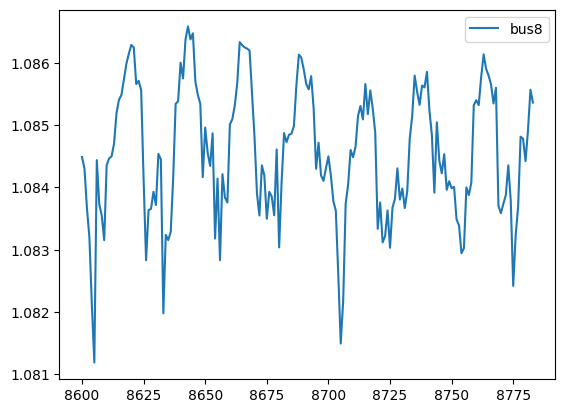

In [6]:
hourly_bus_vm_pu_df.loc[8600: ,'bus8'].plot(label="bus8")
plt.legend()
plt.show()

#### Transform the data into a format better suited for time series transformers
*   Split it into train and test sets.
*   Add categorical features to uniquely identify each bus (time series).
*   Add timestamps and frequency of records to the dataset.
*   The final result is a dataset dictionary containing a train and test dataset.

In [7]:
def create_dataset(in_data, num_series, num_steps, mu=0, sigma=0.01):
    # create target: noise + pattern
    # noise
    # noise = np.random.normal(mu, sigma, size=(num_steps, num_series))

    # target = noise + in_data.to_numpy()
    target = in_data.to_numpy()

    # create categorical static feats: use the sinusoid type as a
    # categorical feature
    item_id = np.array(in_data.columns)
    feat_static_cat = np.array([x for x in range(num_series)])

    return target, item_id, feat_static_cat

In [8]:
# define the parameters of the dataset
num_series = hourly_bus_vm_pu_df.shape[1]
num_steps = hourly_bus_vm_pu_df.shape[0]

custom_ds_metadata = {
    "num_series": num_series,
    "num_steps": num_steps,
    "prediction_length": 24, # last 24 hours.
    "freq": "1H",
    "start": [pd.Period("01-06-2019", freq="1H").to_timestamp() for _ in range(num_series)],
}

In [9]:
data_out = create_dataset(
    hourly_bus_vm_pu_df,
    custom_ds_metadata["num_series"],
    custom_ds_metadata["num_steps"],
)
target, item_id, feat_static_cat = data_out
target = target.transpose()
print(target.shape)

(372, 8784)


In [10]:
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.ITEM_ID: id,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, id, fsc) in zip(
            target[:, :-custom_ds_metadata["prediction_length"]],
            custom_ds_metadata["start"],
            item_id,
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
    use_timestamp= True
)

In [11]:
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.ITEM_ID: id,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, id, fsc) in zip(
            target,
            custom_ds_metadata["start"],
            item_id,
            feat_static_cat,
        )
    ],
    freq=custom_ds_metadata["freq"],
    use_timestamp= True
)

In [12]:
print(train_ds[0])
print(test_ds[0])

{'target': array([1.068, 1.068, 1.068, ..., 1.068, 1.068, 1.068], dtype=float32), 'start': Timestamp('2019-01-06 00:00:00'), 'item_id': 'bus0', 'feat_static_cat': array([0], dtype=int32)}
{'target': array([1.068, 1.068, 1.068, ..., 1.068, 1.068, 1.068], dtype=float32), 'start': Timestamp('2019-01-06 00:00:00'), 'item_id': 'bus0', 'feat_static_cat': array([0], dtype=int32)}


In [13]:
from datasets import Dataset, Features, Value, Sequence, DatasetDict

features  = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        # "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

In [14]:
train = Dataset.from_list(train_ds, features=features)
test = Dataset.from_list(test_ds, features=features)
dataset = DatasetDict({"train": train, "test": test})
dataset

DatasetDict({
    train: Dataset({
        features: ['target', 'start', 'item_id', 'feat_static_cat'],
        num_rows: 372
    })
    test: Dataset({
        features: ['target', 'start', 'item_id', 'feat_static_cat'],
        num_rows: 372
    })
})

## Train Transformer

### Preview Datasets

In [15]:
train_example = dataset['train'][5]
train_example.keys()

dict_keys(['target', 'start', 'item_id', 'feat_static_cat'])

In [16]:
print(train_example['start'])

2019-01-06 00:00:00


In [17]:
test_example = dataset['test'][5]
test_example.keys()

dict_keys(['target', 'start', 'item_id', 'feat_static_cat'])

In [18]:
print(test_example['start'])

2019-01-06 00:00:00


In [19]:
freq = "1H"
prediction_length = custom_ds_metadata["prediction_length"]

assert len(train_example["target"]) + prediction_length == len(
    test_example["target"]
)

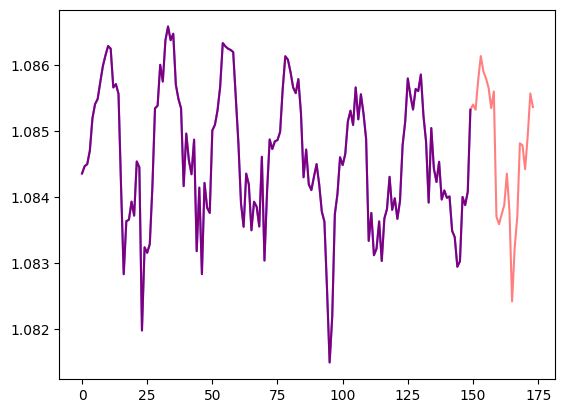

In [20]:
import matplotlib.pyplot as plt

number_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-number_of_samples:], color="blue")
axes.plot(test_example["target"][-number_of_samples-prediction_length:], color="red", alpha=0.5)

plt.show()

In [21]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [22]:
len(train_dataset)

372

### Pre-Process Datasets

In [23]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [24]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [25]:
from gluonts.time_feature import get_lags_for_frequency
print("Freq", freq)
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

Freq 1H
[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [26]:
from gluonts.time_feature import time_features_from_frequency_str
print("Freq", freq)
time_features = time_features_from_frequency_str(freq)
print(time_features)

Freq 1H
[<function hour_of_day at 0x7f2273984310>, <function day_of_week at 0x7f22739840d0>, <function day_of_month at 0x7f22739841f0>, <function day_of_year at 0x7f226d3e7910>]


### Configure Time Series Tranformer Model Parameters

In [27]:
from torch.nn.functional import dropout
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

confif = None
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=[1, 2, 6, 12, 24, 24*7],

    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 372 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 372 possible values:
    embedding_dimension=[2],

    # transformer params:
    dropout=0.3,
    encoder_attention_heads = 4,
    decoder_attention_heads = 4,
    encoder_layers=8,
    decoder_layers=8,
    d_model=32,
)

model=None
model = TimeSeriesTransformerForPrediction(config)

In [28]:
model.config.distribution_output

'student_t'

### Prepare Datasets for the Time Series Transform Model

In [29]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [30]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [31]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [32]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [33]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


### Train and Test Dataloaders

In [34]:
train_dataloader = None
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = None
test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [35]:
batch=None
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())


past_time_features torch.Size([256, 216, 5]) torch.FloatTensor
past_values torch.Size([256, 216]) torch.FloatTensor
past_observed_mask torch.Size([256, 216]) torch.FloatTensor
future_time_features torch.Size([256, 24, 5]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


### Perform a Single Forward Pass

In [36]:
# perform forward pass
outputs=None
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [37]:
print("Loss:", outputs.loss.item())

Loss: 1.6785813570022583


### Train The Model

In [38]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 40
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = None
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
print("Training")
print("[", end="")
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
          static_categorical_features=batch["static_categorical_features"].to(device)
          if config.num_static_categorical_features > 0
          else None,
          static_real_features=batch["static_real_features"].to(device)
          if config.num_static_real_features > 0
          else None,
          past_time_features=batch["past_time_features"].to(device),
          past_values=batch["past_values"].to(device),
          future_time_features=batch["future_time_features"].to(device),
          future_values=batch["future_values"].to(device),
          past_observed_mask=batch["past_observed_mask"].to(device),
          future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())

        if idx % 100 == 0:
            print("=", end="")
print("]")

Training
[========================================]


### View Training Results

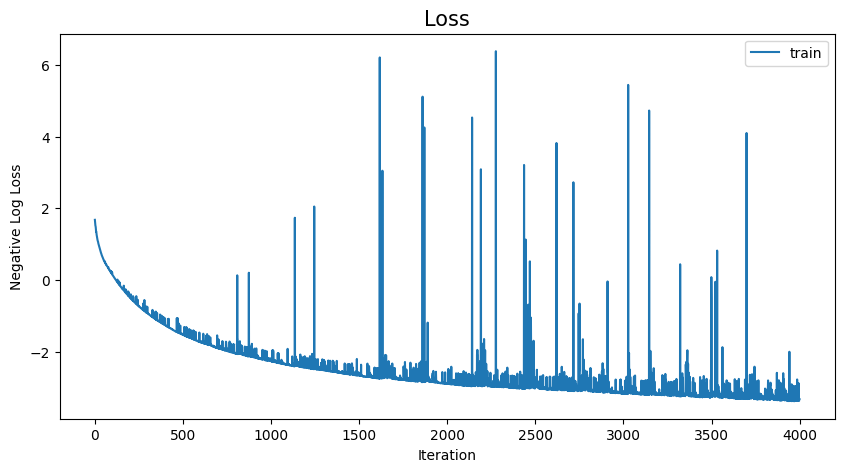

In [39]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Loss")
plt.show()

### Inference

In [40]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


In [41]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(372, 100, 24)


### Plot Prediction vs Ground Truth

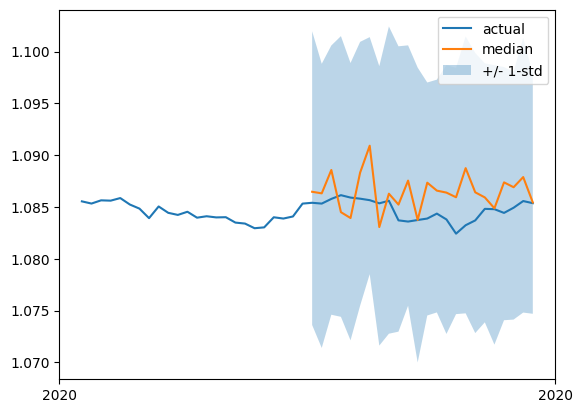

In [42]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:],
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()


plot(5)